## Importing Librarires

In [1]:
import gym
import numpy as np
import pennylane as qml
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import gym.spaces
from gym.envs.registration import register
from gym.envs import toy_text
import torch.nn.functional as F
from torch.distributions import Categorical

c:\Users\Dell\miniconda3\envs\gyenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Binary Wrapper for Frozen Lake

In [2]:
class BinaryWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(BinaryWrapper, self).__init__(env)
        self.bits = int(np.ceil(np.log2(env.observation_space.n)))
        self.observation_space = gym.spaces.MultiBinary(self.bits)

    def observation(self, obs):
        binary = map(float, "{0:b}".format(int(obs)).zfill(self.bits))
        return np.array(list(binary))


## Reward Shaping for Frozen Lake

In [3]:
class ModifiedFL(toy_text.frozen_lake.FrozenLakeEnv):
	def __init__(self, **kwargs):
		super(ModifiedFL, self).__init__(**kwargs)

		self.nS = self.nrow * self.ncol
		self.nA = 4
		for state in range(self.nS): # for all states
			for action in range(self.nA): # for all actions
				my_transitions = []
				for (prob, next_state, _, is_terminal) in self.P[state][action]:
					row = next_state // self.ncol
					col = next_state - row * self.ncol
					tile_type = self.desc[row, col]
					if tile_type == b'H':
						reward = -1.0
					elif tile_type == b'G':
						reward = 10.
					else:
						reward = -0.05

					my_transitions.append((prob, next_state, reward, is_terminal))
				self.P[state][action] = my_transitions

## Defining the VQC Circuit and Model

In [4]:
def encode(n_qubits, inputs):
    for wire in range(n_qubits):
        qml.RX(inputs[wire], wires=wire)


def layer(n_qubits, y_weight, z_weight):
    for wire, y_weight in enumerate(y_weight):
        qml.RY(y_weight, wires=wire)
    for wire, z_weight in enumerate(z_weight):
        qml.RZ(z_weight, wires=wire)
    for wire in range(n_qubits):
        qml.CZ(wires=[wire, (wire + 1) % n_qubits])


def measure(n_qubits):
    return [qml.expval(qml.PauliZ(wire)) for wire in range(n_qubits)]


def get_model(n_qubits, n_layers, data_reupload):
    dev = qml.device("default.qubit", wires=n_qubits)
    shapes = {
        "y_weights": (n_layers, n_qubits),
        "z_weights": (n_layers, n_qubits)
    }

    @qml.qnode(dev, interface='torch')
    def circuit(inputs, y_weights, z_weights):
        for layer_idx in range(n_layers):
            if (layer_idx == 0) or data_reupload:
                encode(n_qubits, inputs)
            layer(n_qubits, y_weights[layer_idx], z_weights[layer_idx])
        return measure(n_qubits)

    model = qml.qnn.TorchLayer(circuit, shapes)

    return model


class QuantumNet(nn.Module):
    def __init__(self, n_layers):
        super(QuantumNet, self).__init__()
        self.n_qubits = 4
        self.n_actions = 4
        self.q_layers = get_model(n_qubits=self.n_qubits,
                                  n_layers=n_layers,
                                  data_reupload=False)

    def forward(self, inputs):
        inputs = inputs * np.pi
        outputs = self.q_layers(inputs)
        outputs = (1 + outputs) / 2
        return outputs


## Registering the New Environment

In [5]:
register(
        id='FrozenLake-VA', # name given to this new environment
        entry_point=__name__+':ModifiedFL', # env entry point
        kwargs={'map_name': '4x4', 'is_slippery': False} # argument passed to the env
)
env = gym.make('FrozenLake-VA')
env = BinaryWrapper(env)


In [6]:
device = torch.device("cpu")

In [7]:
dicts = torch.load("net.pt")
print(dicts)

OrderedDict([('q_layers.y_weights', tensor([[ 4.3494,  1.5357, -0.1915,  0.8213],
        [ 3.8251,  5.3967,  4.4317,  3.8597],
        [ 2.0861,  4.4949,  4.2629,  2.2216],
        [ 2.3797,  1.1265,  0.8281,  4.9177],
        [ 1.7534,  5.2100,  4.6772,  2.4619]])), ('q_layers.z_weights', tensor([[ 0.2604,  2.1938,  6.2150,  2.6293],
        [ 3.1144,  0.6681,  1.9429, -0.5273],
        [ 0.7068,  1.7599,  2.9676,  0.2450],
        [ 4.9197,  2.3943,  3.1300,  4.1747],
        [ 2.1759,  3.5181,  1.7836,  0.5591]]))])


In [8]:
model = QuantumNet(5)
model.load_state_dict(torch.load("net.pt"))

<All keys matched successfully>

In [9]:
model = model.to(device)

## Testing the Agent

In [10]:
def evaluate_agent(env, model, episodes):
    episode_steps = []
    episode_reward = []

    for _ in range(episodes):
        state,_ = env.reset()
        done = False
        episode_steps.append(0)
        episode_reward.append(0)
        while not done:
            state = torch.FloatTensor(state).to(device)
            q_values = model.eval()(state)
            _, action = torch.max(q_values, dim=0)
            action =  int(action.item())
            next_state, reward, terminated, truncated ,_= env.step(action)
            done = terminated or truncated
            state = next_state
            episode_steps[-1] += 1
            episode_reward[-1] += reward

    env.close()
    val = [episode_steps, episode_reward]
    episode_steps = np.mean(episode_steps)
    episode_reward = np.mean(episode_reward)
    return ({'steps': episode_steps, 'reward': episode_reward},val)


In [11]:
dicts, array = evaluate_agent(env, model, 5)

In [12]:
print(array)

[[6, 6, 6, 6, 6], [9.75, 9.75, 9.75, 9.75, 9.75]]


In [13]:
steps, rewards = array

In [15]:
import matplotlib.pyplot as plt

episodes = [1, 2, 3, 4, 5]

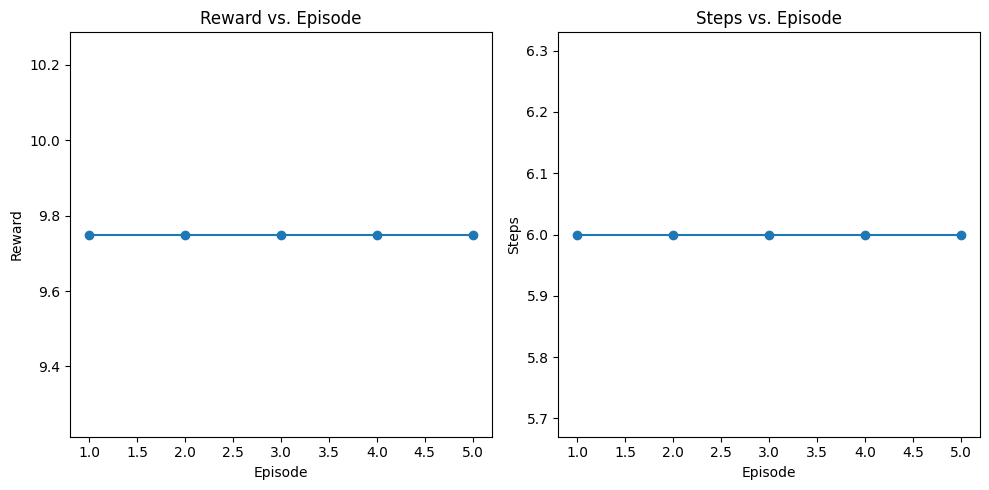

In [16]:
# Plotting rewards vs. episode
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(episodes, rewards, marker='o')
plt.title('Reward vs. Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')

# Plotting steps vs. episode
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(episodes, steps, marker='o')
plt.title('Steps vs. Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()